In [1]:
from google.colab import  drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from sklearn.metrics import classification_report
import numpy

In [3]:
# by default keras automatically converts all images to RGB mode, so no need to convert images, if they are differnet.
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
# apply the data augmentatoin on the dataset and reduce their size for faster (but of course less accurate) learning
img_width, img_height = 64, 64
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Brain-Xray/train',
                                                 target_size = (img_width, img_height),
                                                 batch_size = 32,
                                                 class_mode = 'binary')




Found 3249 images belonging to 2 classes.


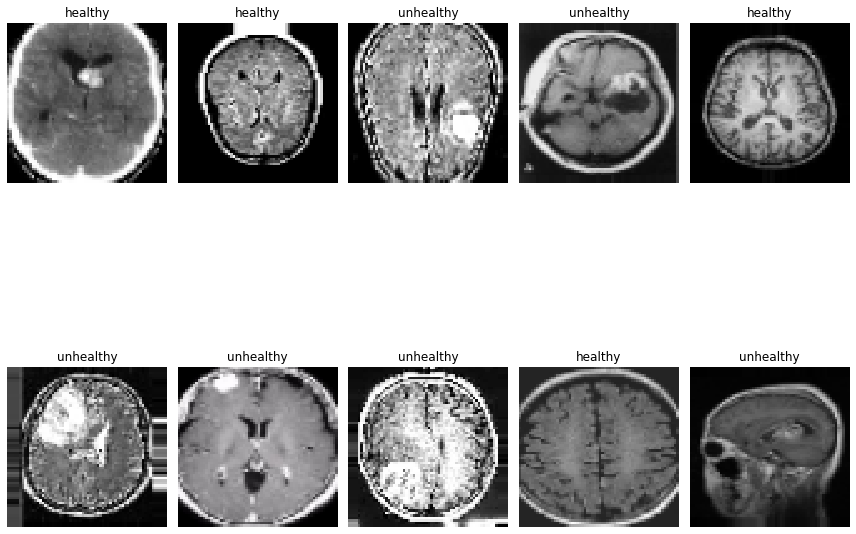

In [4]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in training_set:
        image = X_batch[0]        
        dic = {1:'unhealthy', 0:'healthy'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [5]:
from collections import Counter
cases_count = Counter(training_set.classes)
print(cases_count.items())

dict_items([(0, 1600), (1, 1649)])


In [6]:
total = cases_count[0] + cases_count[1]
weight_for_0 = (1 / cases_count[0]) * (total / 2.0)
weight_for_1 = (1 / cases_count[1]) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

{0: 1.0153125, 1: 0.9851425106124925}


In [7]:
val_datagen = ImageDataGenerator(rescale = 1./255)
val_set = val_datagen.flow_from_directory('/content/drive/MyDrive/Brain-Xray/val',
                                            target_size = (img_width, img_height),
                                            batch_size = 32,
                                            class_mode = 'binary', 
                                            )

Found 498 images belonging to 2 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Brain-Xray/test',
                                            target_size = (img_width, img_height),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle=False)

Found 853 images belonging to 2 classes.


In [9]:
cnn = tf.keras.Sequential()

In [10]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[img_width, img_height, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [11]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 32)         0

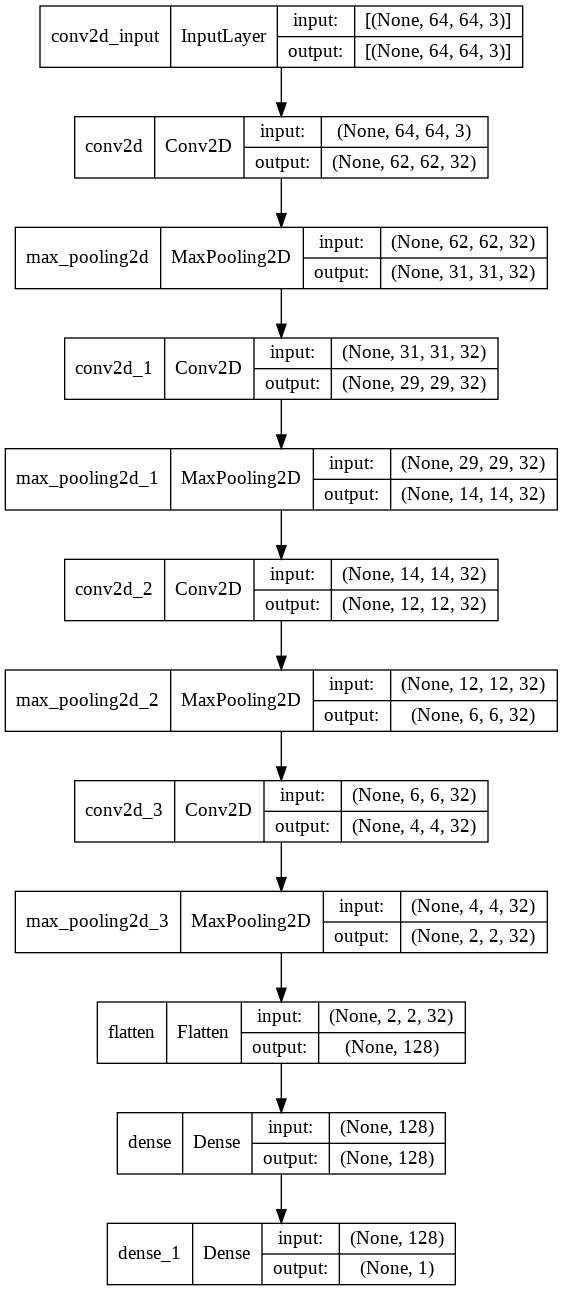

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [13]:
model_fit = cnn.fit(x = training_set, validation_data = val_set, epochs = 25, class_weight=class_weight)

Epoch 1/25
102/102 [==============================] - 603s 6s/step - loss: 0.6660 - accuracy: 0.5956 - val_loss: 0.6147 - val_accuracy: 0.6446
Epoch 2/25
102/102 [==============================] - 22s 215ms/step - loss: 0.5683 - accuracy: 0.7218 - val_loss: 0.6632 - val_accuracy: 0.5884
Epoch 3/25
102/102 [==============================] - 22s 214ms/step - loss: 0.4653 - accuracy: 0.7929 - val_loss: 0.3070 - val_accuracy: 0.8635
Epoch 4/25
102/102 [==============================] - 22s 216ms/step - loss: 0.3885 - accuracy: 0.8384 - val_loss: 0.4531 - val_accuracy: 0.8233
Epoch 5/25
102/102 [==============================] - 22s 218ms/step - loss: 0.3213 - accuracy: 0.8667 - val_loss: 0.3311 - val_accuracy: 0.8614
Epoch 6/25
102/102 [==============================] - 22s 215ms/step - loss: 0.2831 - accuracy: 0.8849 - val_loss: 0.5094 - val_accuracy: 0.8454
Epoch 7/25
102/102 [==============================] - 21s 209ms/step - loss: 0.2307 - accuracy: 0.9141 - val_loss: 0.3192 - val_accu

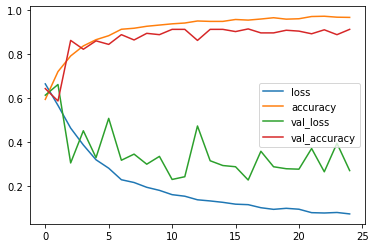

In [14]:
import pandas as pd

pd.DataFrame(cnn.history.history).plot()

In [15]:
model_evaluation = cnn.evaluate(test_set)

27/27 [==============================] - 179s 7s/step - loss: 0.1704 - accuracy: 0.9402


In [16]:
preds = np.round(cnn.predict(test_set),0)

In [17]:
gt_class = test_set.classes
gt_labels = list(test_set.class_indices.keys())
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
cm = confusion_matrix(gt_class, preds)
print(cm)
print('The cnn model has an accuracy score of {:.2f} and recall score of {:.2f} for {:s}'.format((accuracy_score(gt_class, preds) *100),(recall_score(gt_class, preds) *100),gt_labels[1]))

[[350   3]
 [ 48 452]]
The cnn model has an accuracy score of 94.02 and recall score of 90.40 for unhealthy


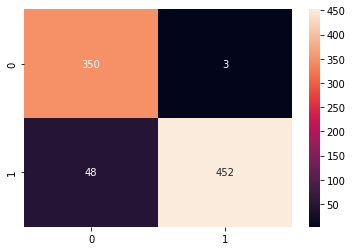

In [18]:
import seaborn as sns
sns.heatmap(cm, annot =True, fmt="d")

In [19]:
report = classification_report(gt_class, preds, target_names=gt_labels)
print(report)

              precision    recall  f1-score   support

     healthy       0.88      0.99      0.93       353
   unhealthy       0.99      0.90      0.95       500

    accuracy                           0.94       853
   macro avg       0.94      0.95      0.94       853
weighted avg       0.95      0.94      0.94       853



(853, 64, 64, 3)
(853,)


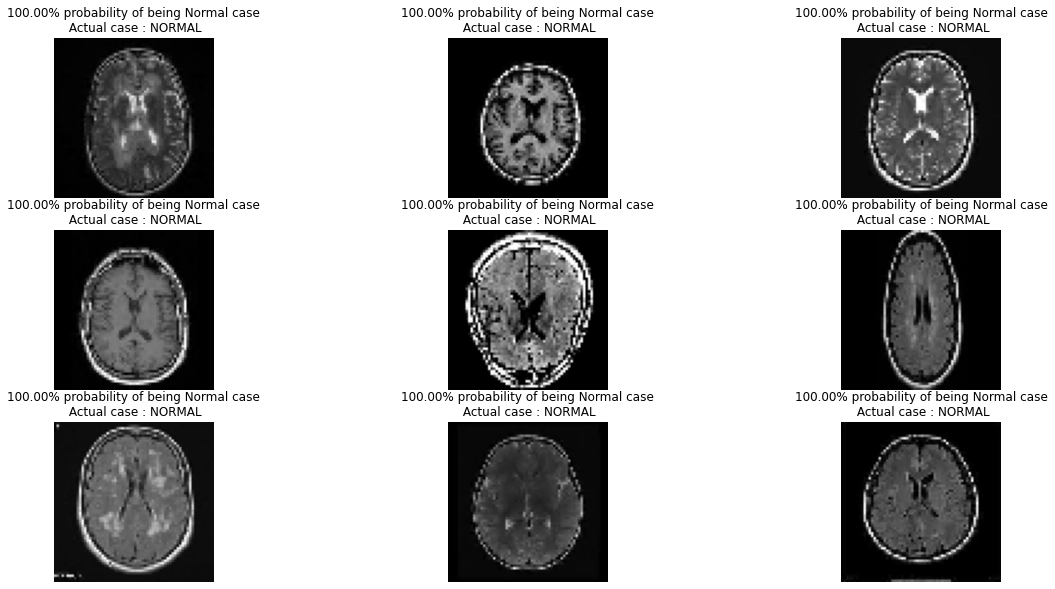

In [20]:
test_set.reset()
x=np.concatenate([test_set.next()[0] for i in range(test_set.__len__())])
y=np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,10))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

In [26]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [24]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(gt_class, preds)

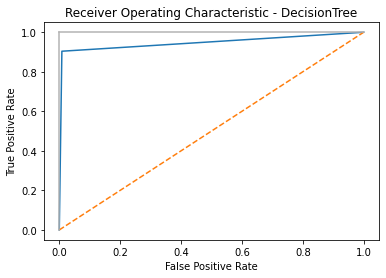

In [28]:
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()